<a href="https://colab.research.google.com/github/sanazy/Persian-Car-Licence-Plate-Detection-and-Recognition/blob/main/Train_CNN_Model_for_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount google drive into colab
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
PATH = "/content/gdrive/MyDrive/DPA/"
%cd {PATH}

/content/gdrive/MyDrive/DPA


## Install and Import libraries

In [3]:
!pip install split-folders -q

In [4]:
import os
import numpy as np
import cv2
import random
import matplotlib.pyplot as plt
import seaborn as sn
import splitfolders

import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.optimizers import SGD

## Download and Split Iranis Dataset

In [5]:
# download iranis dataset into a new directory
%mkdir iranis_dataset
%cd iranis_dataset
!wget https://github.com/alitourani/Iranis-dataset/raw/master/Iranis%20Dataset%20Files.zip

/content/gdrive/MyDrive/DPA/iranis_dataset
--2023-02-21 13:17:28--  https://github.com/alitourani/Iranis-dataset/raw/master/Iranis%20Dataset%20Files.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alitourani/Iranis-dataset/master/Iranis%20Dataset%20Files.zip [following]
--2023-02-21 13:17:28--  https://raw.githubusercontent.com/alitourani/Iranis-dataset/master/Iranis%20Dataset%20Files.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70797614 (68M) [application/zip]
Saving to: ‘Iranis Dataset Files.zip’

Iranis Dataset File 100%[===================>]  67.52M  76.8MB/s    in 0.9s    

2

In [6]:
# unzip dataset
!unzip -q 'Iranis Dataset Files.zip'

In [7]:
# remove zip file
!rm 'Iranis Dataset Files.zip'

In [8]:
# split dataset into train/val/test sets
input_dir = PATH + 'iranis_dataset/'
output_dir = PATH + 'iranis_dataset_split/'

splitfolders.ratio(input_dir, # The location of dataset
                   output = output_dir, # The output location
                   seed = 42, # The number of seed
                   ratio = (.7, .2, .1), # The ratio of splited dataset
                   group_prefix = None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move = False # If you choose to move, turn this into True
                   )

Copying files: 83844 files [15:03, 92.82 files/s] 


## Train a Model for Character Recognition

In [9]:
# define pathes
data_path = PATH + "iranis_dataset_split/" 
train_path = data_path + "train/"
valid_path = data_path + "val/"
test_path = data_path + "test/"

In [10]:
# define image size
IMAGE_SIZE = (32, 32)

In [11]:
class_names = subdirs = [name for name in os.listdir(train_path)]
print("Class names: ", class_names)

num_classes = len(class_names)
print("Number of classes: ", num_classes)

labels_nums = [i for i in range(0,len(class_names))]
print("Label of classes: ", labels_nums)

Class names:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'D', 'Gh', 'H', 'J', 'L', 'M', 'N', 'P', 'PuV', 'PwD', 'Sad', 'Sin', 'T', 'Taxi', 'V', 'Y']
Number of classes:  28
Label of classes:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]


In [12]:
train_images = []
train_labels = []

# save images and their labels for training set
for indx, subdir in enumerate(subdirs):
  imgfolder = os.path.join(train_path, subdir)
  for imgname in os.listdir(imgfolder):
    # read and resize images
    image = cv2.imread(os.path.join(imgfolder, imgname), 0)
    image = cv2.resize(image, IMAGE_SIZE)
    
    train_images.append(image)
    train_labels.append(labels_nums[indx])

c = list(zip(train_images, train_labels))
random.shuffle(c)
train_images, train_labels = zip(*c)

In [14]:
print("individual training image size: ", train_images[0].shape)
print("training images size: ", np.array(train_images).shape)
print("training labels size: ", np.array(train_labels).shape)

individual training image size:  (32, 32)
training images size:  (58678, 32, 32)
training labels size:  (58678,)


In [15]:
val_images = []
val_labels = []

# save images and their labels for validation set
for indx, subdir in enumerate(subdirs):
  imgfolder = os.path.join(valid_path, subdir)
  
  for imgname in os.listdir(imgfolder):
    # read and resize images
    image = cv2.imread(os.path.join(imgfolder, imgname), 0)
    image = cv2.resize(image, IMAGE_SIZE)

    val_images.append(image)
    val_labels.append(labels_nums[indx])

c = list(zip(val_images, val_labels))
random.shuffle(c)
val_images, val_labels = zip(*c)

In [18]:
print("individual validation image size: ", val_images[0].shape)
print("validation images size: ", np.array(val_images).shape)
print("validation labels size: ", np.array(val_labels).shape)

individual validation image size:  (32, 32)
validation images size:  (16759, 32, 32)
validation labels size:  (16759,)


In [19]:
# divide each pixel to 255 for faster and easier computation
X_train = np.array(train_images) / 255.0
# convert a class vector (integers) to binary class matrix
y_train = to_categorical(train_labels, num_classes=num_classes, dtype ="uint8")

print(X_train.shape)
print(y_train.shape)

(58678, 32, 32)
(58678, 28)


In [20]:
X_val = np.array(val_images) / 255.0
y_val = to_categorical(val_labels, num_classes=num_classes, dtype ="uint8")

print(X_val.shape)
print(y_val.shape)

(16759, 32, 32)
(16759, 28)


Class name:  B
Train label:  11
Image size:  (32, 32)


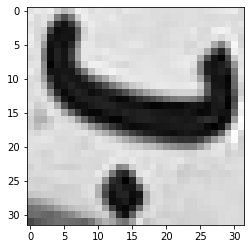

In [21]:
# show arbitrary image from training set
num = 1000
print("Class name: ", class_names[train_labels[num]])
print("Train label: ", train_labels[num])
print("Image size: ", train_images[num].shape)
plt.imshow(train_images[num], cmap='gist_gray')

In [23]:
# define model 
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding='same', 
                 input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

In [24]:
# compile model
opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [25]:
# model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        320       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        36928     
                                                      

In [26]:
# train the model
epochs = 10
history = model.fit(X_train, 
                    y_train, 
                    validation_data = (X_val, y_val),
                    epochs = epochs, 
                    batch_size = 128, 
                    verbose = 1)

Epoch 1/10
459/459 [==============================] - 16s 17ms/step - loss: 1.0444 - accuracy: 0.6987 - val_loss: 0.0938 - val_accuracy: 0.9700
Epoch 2/10
459/459 [==============================] - 7s 16ms/step - loss: 0.1132 - accuracy: 0.9627 - val_loss: 0.0536 - val_accuracy: 0.9827
Epoch 3/10
459/459 [==============================] - 7s 15ms/step - loss: 0.0738 - accuracy: 0.9767 - val_loss: 0.0297 - val_accuracy: 0.9921
Epoch 4/10
459/459 [==============================] - 7s 16ms/step - loss: 0.0510 - accuracy: 0.9852 - val_loss: 0.0211 - val_accuracy: 0.9952
Epoch 5/10
459/459 [==============================] - 7s 15ms/step - loss: 0.0376 - accuracy: 0.9889 - val_loss: 0.0239 - val_accuracy: 0.9942
Epoch 6/10
459/459 [==============================] - 7s 16ms/step - loss: 0.0315 - accuracy: 0.9911 - val_loss: 0.0184 - val_accuracy: 0.9953
Epoch 7/10
459/459 [==============================] - 7s 16ms/step - loss: 0.0247 - accuracy: 0.9930 - val_loss: 0.0150 - val_accuracy: 0.996

In [27]:
def plot_accuracy_loss(history):

  fig = plt.figure(figsize=(18,10))

  # Plot accuracy
  plt.subplot(221)
  plt.plot(history.history['accuracy'],'bo--', label = "acc")
  plt.plot(history.history['val_accuracy'], 'mo--', label = "val_acc")
  plt.title("train_acc vs val_acc")
  plt.ylabel("accuracy")
  plt.xlabel("epochs")
  plt.xticks(np.arange(0, epochs))
  plt.legend()
  plt.grid()

  # Plot loss function
  plt.subplot(222)
  plt.plot(history.history['loss'],'bo--', label = "loss")
  plt.plot(history.history['val_loss'], 'mo--', label = "val_loss")
  plt.title("train_loss vs val_loss")
  plt.ylabel("loss")
  plt.xlabel("epochs")
  plt.xticks(np.arange(0, epochs))
  plt.legend()
  plt.grid()

  plt.show()

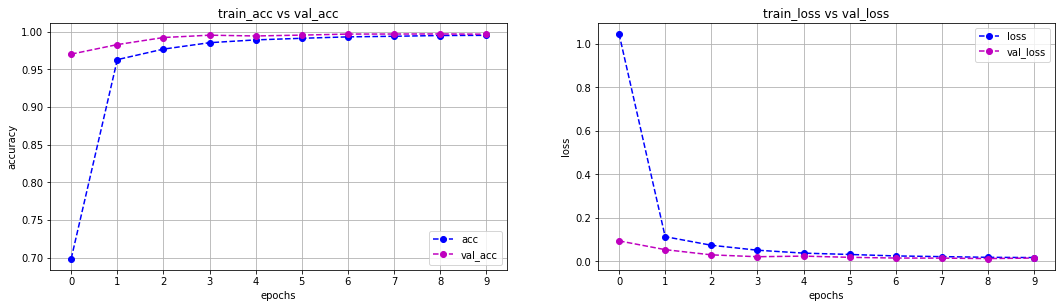

In [28]:
# plot accuracy and loss functions for train and train and validation sets 
plot_accuracy_loss(history)

In [29]:
# save the model
model_path = PATH + 'ocr_model'
model.save(model_path)

## Test the trained model on test data

In [30]:
# load the model
ocr_model = tf.keras.models.load_model(model_path)

In [31]:
test_images = []
test_labels = []

# save images and their labels for test set
for indx, subdir in enumerate(subdirs):
  imgfolder = os.path.join(test_path, subdir)
  
  for imgname in os.listdir(imgfolder):
    # read and resize images
    image = cv2.imread(os.path.join(imgfolder, imgname), 0)
    image = cv2.resize(image, IMAGE_SIZE)
    
    test_images.append(image)
    test_labels.append(labels_nums[indx])

c = list(zip(test_images, test_labels))
random.shuffle(c)
test_images, test_labels = zip(*c)

In [32]:
print("individual test image size: ", test_images[0].shape)
print("test images size: ", np.array(test_images).shape)
print("test labels size: ", np.array(test_labels).shape)

individual test image size:  (32, 32)
test images size:  (8407, 32, 32)
test labels size:  (8407,)


In [33]:
X_test = np.array(test_images) / 255.0

print(X_test.shape)

(8407, 32, 32)


In [34]:
# predict the class of test set 
y_predicted = ocr_model.predict(X_test)

# assign corresponding label of predictions 
y_predicted_labels = [np.argmax(i) for i in y_predicted]

263/263 [==============================] - 1s 3ms/step


Predicted class name:  V
Predicted label:  26


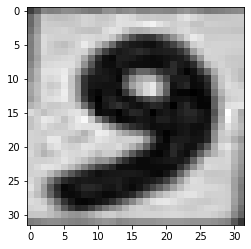

In [37]:
#‌ show an arbitrary image from test sets
num = 100
print("Predicted class name: ", class_names[np.argmax(y_predicted[num])])
print("Predicted label: ", y_predicted_labels[num])
plt.imshow(test_images[num], cmap='gist_gray')

Text(69.0, 0.5, 'Truth')

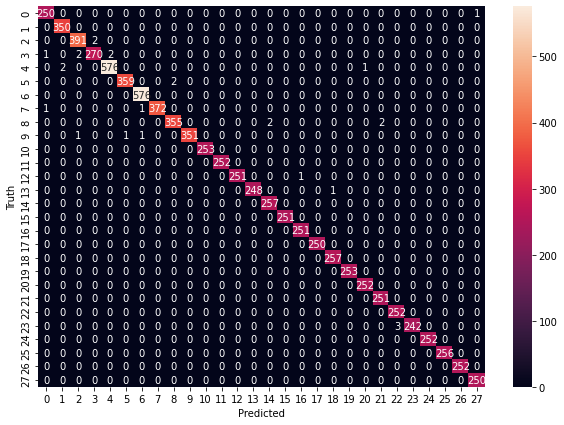

In [38]:
# confusion matrix for all classes
cm = tf.math.confusion_matrix(labels=test_labels, predictions=y_predicted_labels)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')